# Exploratory Data Analysis & Pre-processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate


In [3]:
df = pd.read_csv("traffics.csv")

In [4]:
df

,Timestamp,Location,Vehicle_Count,Vehicle_Speed,Congestion_Level,Peak_Off_Peak,Target_Vehicle_Count
0,2024-01-01 00:00:00,Sensor_02,63,55.680777,1,Off-Peak,50
1,2024-01-01 00:15:00,Sensor_04,50,76.680379,0,Off-Peak,42
2,2024-01-01 00:30:00,Sensor_02,42,48.598038,2,Off-Peak,55
3,2024-01-01 00:45:00,Sensor_02,55,59.796931,1,Off-Peak,46
4,2024-01-01 01:00:00,Sensor_01,46,48.094884,2,Off-Peak,48
...,...,...,...,...,...,...,...
195,2024-01-03 00:45:00,Sensor_03,39,59.183284,0,Off-Peak,49
196,2024-01-03 01:00:00,Sensor_01,49,46.307568,5,Off-Peak,55
197,2024-01-03 01:15:00,Sensor_04,55,66.316120,2,Peak,41
198,2024-01-03 01:30:00,Sensor_04,41,43.039720,3,Off-Peak,48


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             200 non-null    object 
 1   Location              200 non-null    object 
 2   Vehicle_Count         200 non-null    int64  
 3   Vehicle_Speed         200 non-null    float64
 4   Congestion_Level      200 non-null    int64  
 5   Peak_Off_Peak         200 non-null    object 
 6   Target_Vehicle_Count  200 non-null    int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 11.1+ KB


In [6]:
df.isnull().sum()

Timestamp               0
Location                0
Vehicle_Count           0
Vehicle_Speed           0
Congestion_Level        0
Peak_Off_Peak           0
Target_Vehicle_Count    0
dtype: int64

In [7]:
df.dtypes

Timestamp                object
Location                 object
Vehicle_Count             int64
Vehicle_Speed           float64
Congestion_Level          int64
Peak_Off_Peak            object
Target_Vehicle_Count      int64
dtype: object

In [8]:
df.describe()

,Vehicle_Count,Vehicle_Speed,Congestion_Level,Target_Vehicle_Count
count,200.000000,200.000000,200.000000,200.000000
mean,50.200000,61.599073,1.290000,50.125000
std,6.611244,10.137435,1.262485,6.550106
min,29.000000,34.704787,0.000000,29.000000
25%,46.000000,55.236558,0.000000,46.000000
50%,50.000000,61.746936,1.000000,50.000000
75%,55.000000,68.827132,2.000000,55.000000
max,68.000000,90.902295,5.000000,68.000000


# Metode dan Eksperimen

## Metode Mamdani

In [12]:
# Fungsi fuzzifikasi
def fuzzification(value, ranges):
    result = {"low": 0, "medium": 0, "high": 0}
    low = ranges["low"]
    medium = ranges["medium"]
    high = ranges["high"]
    
    # low
    if value <= low[2]:
        result["low"] = max(0, min(1, (low[2] - value) / (low[2] - low[0]) if value > low[0] else 1))
    
    # medium
    if medium[0] <= value <= medium[2]:
        result["medium"] = max(0, min(1, (value - medium[0]) / (medium[1] - medium[0]) if value < medium[1] else (medium[2] - value) / (medium[2] - medium[1])))

    # high
    if value >= high[0]:
        result["high"] = max(0, min(1, ((value - high[0]) / (high[1] - high[0]) if value < high[1] else 1)))        
    
    return result

# Rentang keanggotaan fuzzy berdasarkan deskripsi data
proporsi_ranges = {
    "Vehicle_Count": {
        "low": (29.0, 46.0, 50.0),
        "medium": (46.0, 50.0, 55.0),
        "high": (50.0, 55.0, 68.0)
    },
    "Vehicle_Speed": {
        "low": (34.70, 55.23, 61.74),
        "medium": (55.23, 61.74, 68.82),
        "high": (61.74, 68.82, 90.90)
    },
    "Congestion_Level": {
        "low": (0.0, 0.0, 1.0),
        "medium": (0.0, 1.0, 2.0),
        "high": (1.0, 2.0, 5.0)
    }
}

# Output crisp untuk defuzzifikasi
output_crisp = {"low": 1, "medium": 3, "high": 5}

# Aturan fuzzy
rules = {
    ("low", "low", "low"): "low",
    ("low", "low", "medium"): "low",
    ("low", "low", "high"): "low",
    ("low", "medium", "low"): "medium",
    ("low", "medium", "medium"): "medium",
    ("low", "medium", "high"): "medium",
    ("low", "high", "low"): "high",
    ("low", "high", "medium"): "high",
    ("low", "high", "high"): "high",
    ("medium", "low", "low"): "low",
    ("medium", "low", "medium"): "medium",
    ("medium", "low", "high"): "medium",
    ("medium", "medium", "low"): "medium",
    ("medium", "medium", "medium"): "medium",
    ("medium", "medium", "high"): "medium",
    ("medium", "high", "low"): "high",
    ("medium", "high", "medium"): "high",
    ("medium", "high", "high"): "high",
    ("high", "low", "low"): "high",
    ("high", "low", "medium"): "high",
    ("high", "low", "high"): "high",
    ("high", "medium", "low"): "high",
    ("high", "medium", "medium"): "high",
    ("high", "medium", "high"): "high",
    ("high", "high", "low"): "high",
    ("high", "high", "medium"): "high",
    ("high", "high", "high"): "high"
}

# Fungsi untuk mendapatkan label linguistik tertinggi
def get_linguistic_label(membership):
    return max(membership, key=membership.get)

# Evaluasi aturan fuzzy
def evaluate_rule(label_Count, label_Speed, label_Congestion):
    return rules.get((label_Count, label_Speed, label_Congestion), "Output Tidak Diketahui")

# Defuzzifikasi menggunakan metode Centroid
def defuzzify(membership_values):
    numerator = 0
    denominator = 0
    for label, value in membership_values.items():
        numerator += output_crisp[label] * value
        denominator += value
    return numerator / denominator if denominator != 0 else 0

# Mengaplikasikan fuzzifikasi dan aturan fuzzy
results = []
for index, row in df.iterrows():
    memberships = {
        'Vehicle_Count': fuzzification(row['Vehicle_Count'], proporsi_ranges['Vehicle_Count']),
        'Vehicle_Speed': fuzzification(row['Vehicle_Speed'], proporsi_ranges['Vehicle_Speed']),
        'Congestion_Level': fuzzification(row['Congestion_Level'], proporsi_ranges['Congestion_Level'])
    }
    # Mendapatkan label linguistik
    labels = {year: get_linguistic_label(memberships[year]) for year in memberships}
    # Evaluasi aturan fuzzy
    inferred_output = evaluate_rule(labels['Vehicle_Count'], labels['Vehicle_Speed'], labels['Congestion_Level'])
    # Agregasi untuk defuzzifikasi
    aggregated_output = {label: min(memberships['Vehicle_Count'][label], memberships['Vehicle_Speed'][label], memberships['Congestion_Level'][label]) for label in ['low', 'medium', 'high']}
    crisp_output = defuzzify(aggregated_output)
    results.append({
        'Location': row['Location'],
        'Vehicle_Count': memberships['Vehicle_Count'],
        'Vehicle_Speed': memberships['Vehicle_Speed'],
        'Congestion_Level': memberships['Congestion_Level'],
        'Inferred_Output': inferred_output,
        'Crisp_Output': crisp_output
    })

# Menampilkan tabel hasil
table_data = [
    [
        result['Location'],
        result['Vehicle_Count']['low'], result['Vehicle_Count']['medium'], result['Vehicle_Count']['high'],
        result['Vehicle_Speed']['low'], result['Vehicle_Speed']['medium'], result['Vehicle_Speed']['high'],
        result['Congestion_Level']['low'], result['Congestion_Level']['medium'], result['Congestion_Level']['high'],
        result['Inferred_Output'], result['Crisp_Output']
    ]
    for result in results
]

headers = [
    "Location",
    "Vehicle_Count (low)", "Vehicle_Count (medium)", "Vehicle_Count (high)",
    "Vehicle_Speed (low)", "Vehicle_Speed (medium)", "Vehicle_Speed (high)",
    "Congestion_Level (low)", "Congestion_Level (medium)", "Congestion_Level (high)",
    "Inferred Output", "Crisp Output"
]

print(tabulate(table_data, headers=headers, tablefmt="grid"))


+------------+-----------------------+--------------------------+------------------------+-----------------------+--------------------------+------------------------+--------------------------+-----------------------------+---------------------------+-------------------+----------------+
| Location   |   Vehicle_Count (low) |   Vehicle_Count (medium) |   Vehicle_Count (high) |   Vehicle_Speed (low) |   Vehicle_Speed (medium) |   Vehicle_Speed (high) |   Congestion_Level (low) |   Congestion_Level (medium) |   Congestion_Level (high) | Inferred Output   |   Crisp Output |
+============+=======================+==========================+========================+=======================+==========================+========================+==========================+=============================+===========================+===================+================+
| Sensor_02  |             0         |                     0    |                    1   |           0.224084    |               0.06

### Inferred Output
Hasil inferensi fuzzy berupa kategori linguistik: low, medium, atau high.

- low:

Lalu lintas cenderung lancar, dengan jumlah kendaraan yang relatif sedikit, kecepatan kendaraan cukup tinggi, dan tingkat kemacetan sangat rendah.
Misalnya, pada lokasi Loc1, inferensi fuzzy menunjukkan low, yang berarti tingkat kemacetan hampir tidak ada.

- medium:

Lalu lintas menunjukkan tanda-tanda kepadatan, dengan kecepatan kendaraan mulai menurun, tetapi masih belum mencapai kemacetan tinggi.
Lokasi dengan hasil inferensi ini mungkin memiliki arus lalu lintas yang stabil tetapi cukup sibuk, sehingga memerlukan perhatian.

- high:

Lalu lintas sangat padat, dengan jumlah kendaraan tinggi, kecepatan rendah, dan tingkat kemacetan sangat parah.
Lokasi dengan inferensi ini memerlukan intervensi untuk mengurangi kemacetan, seperti pengaturan ulang lalu lintas atau penambahan kapasitas jalan.

### Crisp Output
Hasil defuzzifikasi berupa nilai kontinu, yang memberikan informasi kuantitatif mengenai tingkat kemacetan.

Nilai ini dihitung dengan metode Centroid menggunakan bobot kategori linguistik: `low = 1, medium = 3, high = 5.`

- Crisp Output = 1.0 - 2.0:

Hasil ini mendekati kategori `low`, yang menunjukkan bahwa lokasi ini memiliki lalu lintas yang sangat lancar dengan kemacetan minimal.
- Crisp Output = 2.0 - 4,0:

Nilai ini berada di antara `low dan medium`, mengindikasikan bahwa lalu lintas cukup ramai tetapi belum mencapai kemacetan yang signifikan.
- Crisp Output = 4.5 - 5.0:

Hasil ini mendekati kategori `high`, menunjukkan lalu lintas yang sangat padat dengan tingkat kemacetan parah.

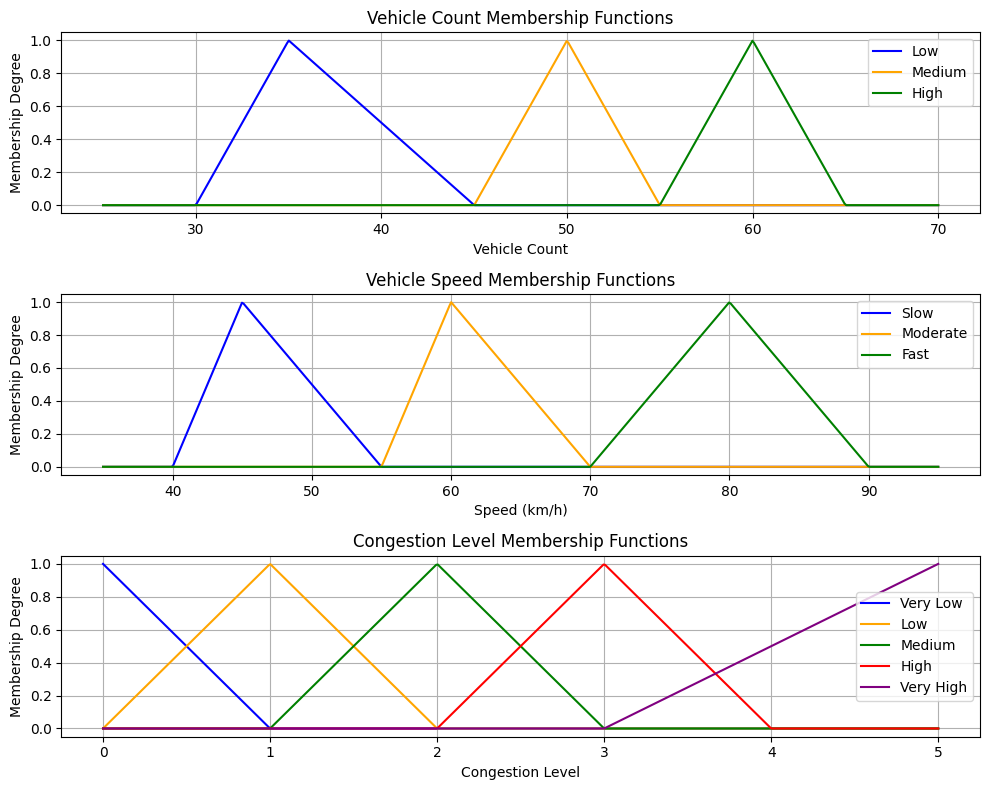

In [13]:
# Fungsi keanggotaan untuk Vehicle Count
def vehicle_count_low(x):
    return np.maximum(0, np.minimum((x - 30) / (35 - 30), (45 - x) / (45 - 35)))

def vehicle_count_medium(x):
    return np.maximum(0, np.minimum((x - 45) / (50 - 45), (55 - x) / (55 - 50)))

def vehicle_count_high(x):
    return np.maximum(0, np.minimum((x - 55) / (60 - 55), (65 - x) / (65 - 60)))

# Fungsi keanggotaan untuk Vehicle Speed
def vehicle_speed_slow(x):
    return np.maximum(0, np.minimum((x - 40) / (45 - 40), (55 - x) / (55 - 45)))

def vehicle_speed_moderate(x):
    return np.maximum(0, np.minimum((x - 55) / (60 - 55), (70 - x) / (70 - 60)))

def vehicle_speed_fast(x):
    return np.maximum(0, np.minimum((x - 70) / (80 - 70), (90 - x) / (90 - 80)))

# Fungsi keanggotaan untuk Congestion Level
def congestion_very_low(x):
    return np.maximum(0, np.minimum(1, 1 - x))

def congestion_low(x):
    return np.maximum(0, np.minimum(x, 2 - x))

def congestion_medium(x):
    return np.maximum(0, np.minimum(x - 1, 3 - x))

def congestion_high(x):
    return np.maximum(0, np.minimum(x - 2, 4 - x))

def congestion_very_high(x):
    return np.maximum(0, np.minimum((x - 3) / (5 - 3), 1))

# Plotting fungsi keanggotaan
def plot_membership_functions():
    x_vehicle_count = np.linspace(25, 70, 500)
    x_vehicle_speed = np.linspace(35, 95, 500)
    x_congestion_level = np.linspace(0, 5, 500)

 # Vehicle Count
    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(x_vehicle_count, vehicle_count_low(x_vehicle_count), label='Low', color='blue')
    plt.plot(x_vehicle_count, vehicle_count_medium(x_vehicle_count), label='Medium', color='orange')
    plt.plot(x_vehicle_count, vehicle_count_high(x_vehicle_count), label='High', color='green')
    plt.title('Vehicle Count Membership Functions')
    plt.xlabel('Vehicle Count')
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid()

    # Vehicle Speed
    plt.subplot(3, 1, 2)
    plt.plot(x_vehicle_speed, vehicle_speed_slow(x_vehicle_speed), label='Slow', color='blue')
    plt.plot(x_vehicle_speed, vehicle_speed_moderate(x_vehicle_speed), label='Moderate', color='orange')
    plt.plot(x_vehicle_speed, vehicle_speed_fast(x_vehicle_speed), label='Fast', color='green')
    plt.title('Vehicle Speed Membership Functions')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid()

    # Congestion Level
    plt.subplot(3, 1, 3)
    plt.plot(x_congestion_level, congestion_very_low(x_congestion_level), label='Very Low', color='blue')
    plt.plot(x_congestion_level, congestion_low(x_congestion_level), label='Low', color='orange')
    plt.plot(x_congestion_level, congestion_medium(x_congestion_level), label='Medium', color='green')
    plt.plot(x_congestion_level, congestion_high(x_congestion_level), label='High', color='red')
    plt.plot(x_congestion_level, congestion_very_high(x_congestion_level), label='Very High', color='purple')
    plt.title('Congestion Level Membership Functions')
    plt.xlabel('Congestion Level')
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi untuk memplot grafik keanggotaan
plot_membership_functions()

## Fungsi Keanggotaan Jumlah Kendaraan
Grafik ini menggambarkan bagaimana jumlah kendaraan dikategorikan ke dalam tiga himpunan fuzzy: Rendah, Sedang, dan Tinggi. Semakin tinggi nilai keanggotaan, semakin cocok data dengan kategori tersebut.

- Rendah: Jumlah kendaraan dianggap rendah jika nilainya berada di sekitar `30-45`.
- Sedang: Jumlah kendaraan dianggap sedang jika nilainya berada di sekitar `45-55`.
- Tinggi: Jumlah kendaraan dianggap tinggi jika nilainya berada di sekitar `55-65`.

## Metode Sugeno

In [14]:
# Membaca data dari file CSV
data = pd.read_csv('traffics.csv')

# Mendefinisikan rentang proporsi untuk fuzzifikasi
proporsi_ranges = {
    'Vehicle_Count': {
        'low': (0, 30),
        'medium': (30, 70),
        'high': (70, 100)
    },
    'Vehicle_Speed': {
        'low': (0, 40),
        'medium': (40, 80),
        'high': (80, 100)
    },
    'Congestion_Level': {
        'low': (0, 1),
        'medium': (1, 2),
        'high': (2, 3)
    }
}

# Fungsi untuk fuzzifikasi
def fuzzification(value, ranges):
    memberships = {}
    for label, (low, high) in ranges.items():
        if value < low:
            memberships[label] = 0
        elif low <= value <= high:
            memberships[label] = (value - low) / (high - low)
        else:
            memberships[label] = 1
    return memberships

# Aturan fuzzy Sugeno
sugeno_rules = {
    ("low", "low", "low"): 10,
    ("low", "low", "medium"): 20,
    ("low", "low", "high"): 30,
    ("low", "medium", "low"): 40,
    ("low", "medium", "medium"): 50,
    ("low", "medium", "high"): 60,
    ("low", "high", "low"): 70,
    ("low", "high", "medium"): 80,
    ("low", "high", "high"): 90,
    ("medium", "low", "low"): 100,
    ("medium", "low", "medium"): 110,
    ("medium", "low", "high"): 120,
    ("medium", "medium", "low"): 130,
    ("medium", "medium", "medium"): 140,
    ("medium", "medium", "high"): 150,
    ("medium", "high", "low"): 160,
    ("medium", "high", "medium"): 170,
    ("medium", "high", "high"): 180,
    ("high", "low", "low"): 190,
    ("high", "low", "medium"): 200,
    ("high", "low", "high"): 210,
    ("high", "medium", "low"): 220,
    ("high", "medium", "medium"): 230,
    ("high", "medium", "high"): 240,
    ("high", "high", "low"): 250,
    ("high", "high", "medium"): 260,
    ("high", "high", "high"): 270
}

# Menghitung output Sugeno
def sugeno_inference(memberships):
    numerator = 0
    denominator = 0

    for rule, output in sugeno_rules.items():
        # Mengambil nilai keanggotaan dari label pada aturan
        rule_firing_strength = min(
            memberships['Vehicle_Count'][rule[0]],
            memberships['Vehicle_Speed'][rule[1]],
            memberships['Congestion_Level'][rule[2]]
        )
        numerator += rule_firing_strength * output
        denominator += rule_firing_strength

    # Jika tidak ada aturan yang berlaku menghasilkan 0
    return numerator / denominator if denominator != 0 else 0

# Mengaplikasikan fuzzifikasi dan aturan fuzzy Sugeno
results = []
for index, row in data.iterrows():
    memberships = {
        'Vehicle_Count': fuzzification(row['Vehicle_Count'], proporsi_ranges['Vehicle_Count']),
        'Vehicle_Speed': fuzzification(row['Vehicle_Speed'], proporsi_ranges['Vehicle_Speed']),
        'Congestion_Level': fuzzification(row['Congestion_Level'], proporsi_ranges['Congestion_Level'])
    }

    # Evaluasi aturan Sugeno
    output = sugeno_inference(memberships)
    
    # Menyimpan hasil
    results.append({
        'Location': row['Location'],
        'Count_low': memberships['Vehicle_Count']['low'],
        'Count_medium': memberships['Vehicle_Count']['medium'],
        'Count_high': memberships['Vehicle_Count']['high'],
        'Speed_low': memberships['Vehicle_Speed']['low'],
        'Speed_medium': memberships['Vehicle_Speed']['medium'],
        'Speed_high': memberships['Vehicle_Speed']['high'],
        'Congestion_low': memberships['Congestion_Level']['low'],
        'Congestion_medium': memberships['Congestion_Level']['medium'],
        'Congestion_high': memberships['Congestion_Level']['high'],
        'Output': output
    })

# Menampilkan tabel hasil
table_data = [
    [
        result['Location'],
        result['Count_low'], result['Count_medium'], result['Count_high'],
        result['Speed_low'], result['Speed_medium'], result['Speed_high'],
        result['Congestion_low'], result['Congestion_medium'], result['Congestion_high'],
        result['Output']
    ]
    for result in results
]

headers = [
    "Location",
    "Count Low", "Count Medium", "Count High",
    "Speed Low", "Speed Medium", "Speed High",
    "Congestion Low", "Congestion Medium", "Congestion High",
    "Output"
]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


+------------+-------------+----------------+--------------+-------------+----------------+--------------+------------------+---------------------+-------------------+----------+
| Location   |   Count Low |   Count Medium |   Count High |   Speed Low |   Speed Medium |   Speed High |   Congestion Low |   Congestion Medium |   Congestion High |   Output |
+============+=============+================+==============+=============+================+==============+==================+=====================+===================+==========+
| Sensor_02  |    1        |          0.825 |            0 |    1        |      0.392019  |    0         |                1 |                   0 |                 0 |  60.9969 |
+------------+-------------+----------------+--------------+-------------+----------------+--------------+------------------+---------------------+-------------------+----------+
| Sensor_04  |    1        |          0.5   |            0 |    1        |      0.917009  |    0         

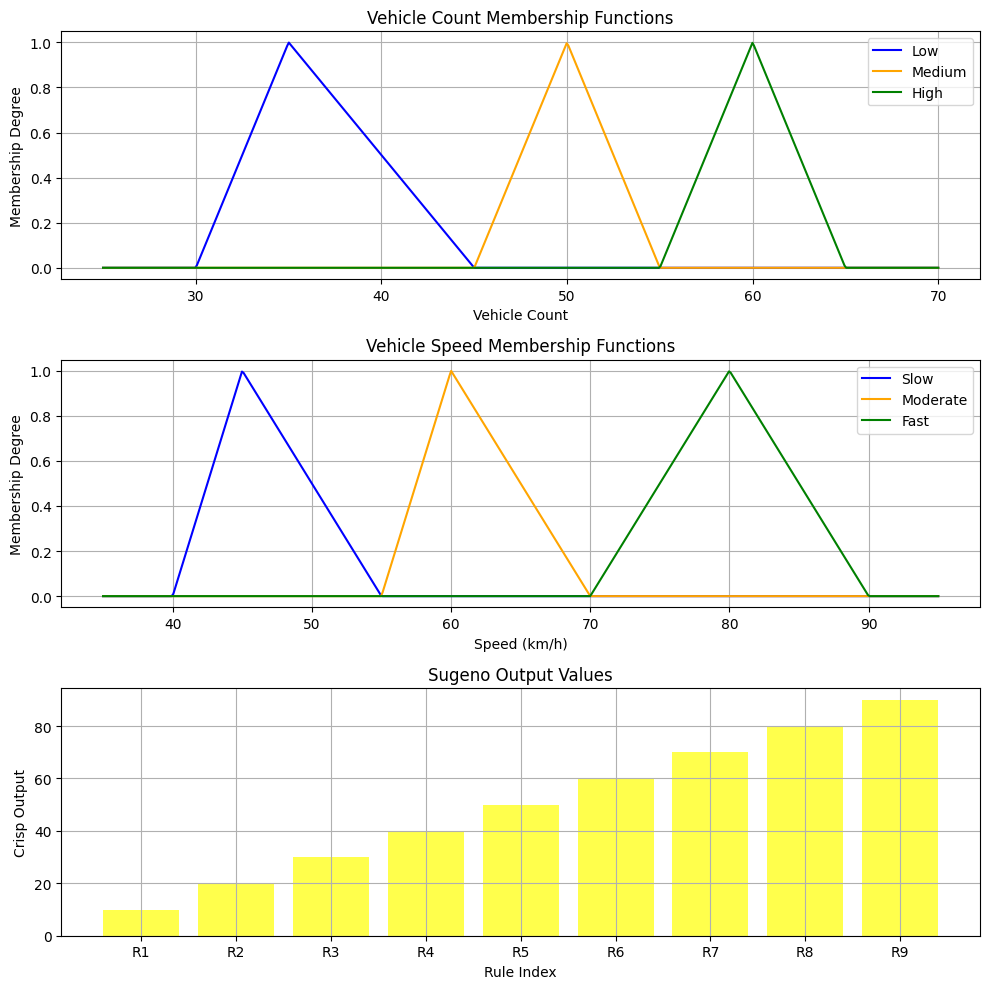

In [18]:
# Fungsi keanggotaan untuk Vehicle Count
def vehicle_count_low(x):
    return np.maximum(0, np.minimum((x - 30) / (35 - 30), (45 - x) / (45 - 35)))

def vehicle_count_medium(x):
    return np.maximum(0, np.minimum((x - 45) / (50 - 45), (55 - x) / (55 - 50)))

def vehicle_count_high(x):
    return np.maximum(0, np.minimum((x - 55) / (60 - 55), (65 - x) / (65 - 60)))

# Fungsi keanggotaan untuk Vehicle Speed
def vehicle_speed_slow(x):
    return np.maximum(0, np.minimum((x - 40) / (45 - 40), (55 - x) / (55 - 45)))

def vehicle_speed_moderate(x):
    return np.maximum(0, np.minimum((x - 55) / (60 - 55), (70 - x) / (70 - 60)))

def vehicle_speed_fast(x):
    return np.maximum(0, np.minimum((x - 70) / (80 - 70), (90 - x) / (90 - 80)))

# Sugeno rules output values
def sugeno_rule_output(vehicle_count, vehicle_speed):
    if vehicle_count == "low" and vehicle_speed == "slow":
        return 10
    elif vehicle_count == "low" and vehicle_speed == "moderate":
        return 20
    elif vehicle_count == "low" and vehicle_speed == "fast":
        return 30
    elif vehicle_count == "medium" and vehicle_speed == "slow":
        return 40
    elif vehicle_count == "medium" and vehicle_speed == "moderate":
        return 50
    elif vehicle_count == "medium" and vehicle_speed == "fast":
        return 60
    elif vehicle_count == "high" and vehicle_speed == "slow":
        return 70
    elif vehicle_count == "high" and vehicle_speed == "moderate":
        return 80
    elif vehicle_count == "high" and vehicle_speed == "fast":
        return 90
    return 0

# Visualisasi fungsi keanggotaan
def plot_sugeno_membership_functions():
    x_vehicle_count = np.linspace(25, 70, 500)
    x_vehicle_speed = np.linspace(35, 95, 500)
    output_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]  # Sugeno crisp outputs
    
    # Vehicle Count
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.plot(x_vehicle_count, vehicle_count_low(x_vehicle_count), label='Low', color='blue')
    plt.plot(x_vehicle_count, vehicle_count_medium(x_vehicle_count), label='Medium', color='orange')
    plt.plot(x_vehicle_count, vehicle_count_high(x_vehicle_count), label='High', color='green')
    plt.title('Vehicle Count Membership Functions')
    plt.xlabel('Vehicle Count')
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid()

    # Vehicle Speed
    plt.subplot(3, 1, 2)
    plt.plot(x_vehicle_speed, vehicle_speed_slow(x_vehicle_speed), label='Slow', color='blue')
    plt.plot(x_vehicle_speed, vehicle_speed_moderate(x_vehicle_speed), label='Moderate', color='orange')
    plt.plot(x_vehicle_speed, vehicle_speed_fast(x_vehicle_speed), label='Fast', color='green')
    plt.title('Vehicle Speed Membership Functions')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid()

    # Sugeno Output
    plt.subplot(3, 1, 3)
    plt.bar(range(len(output_values)), output_values, color='yellow', alpha=0.7)
    plt.title('Sugeno Output Values')
    plt.xlabel('Rule Index')
    plt.ylabel('Crisp Output')
    plt.xticks(range(len(output_values)), [f'R{i+1}' for i in range(len(output_values))])
    plt.grid()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi untuk memplot grafik keanggotaan dan output Sugeno
plot_sugeno_membership_functions()